In [1]:
import numpy as np
import pickle as pcl

from methods.training import load_data

from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from keras.models import load_model

%matplotlib inline
import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

Using TensorFlow backend.


In [2]:
from predict import predict

In [3]:
si = predict(fname='data/full_histories_illustris.h5')
si.training_mask()
si.filename

'data/full_histories_illustris.h5'

In [4]:
predictors = si.load_arr('log_8','SFH')

SMAPE = {'ERT Intrinsic': None, 'ERT Dust': None, 'CNN Intrinsic': None, 'CNN Dust': None}

## ERT / CNN

#### ERT

In [5]:
def custom_SMAPE(y_true, y_pred):
    return np.mean(si._SMAPE(y_true, y_pred))

In [6]:
features = si.prepare_features(key='Intrinsic', CNN=False)

ert_intrinsic = pcl.load(open('data/ert_trained_intrinsic.p', 'rb'))
prediction = ert_intrinsic.best_estimator_.predict(features[~si.train])

SMAPE['ERT Intrinsic'] = [si._SMAPE(predictors[~si.train][i], prediction[i]) \
                          * 100 for i in range(len(prediction))]

features = si.prepare_features(key='Dust', CNN=False)

ert_intrinsic = pcl.load(open('data/ert_trained_dust.p', 'rb'))
prediction = ert_intrinsic.best_estimator_.predict(features[~si.train])

SMAPE['ERT Dust'] = [si._SMAPE(predictors[~si.train][i], prediction[i]) \
                     * 100 for i in range(len(prediction))]

#### CNN

In [7]:
# intrinsic
features = si.prepare_features(key='Intrinsic', CNN=True)

cnn_model = load_model('data/cnn_trained_illustris_intrinsic.h5', 
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

prediction = cnn_model.predict(features[~si.train])

SMAPE['CNN Intrinsic'] = [si._SMAPE(predictors[~si.train][i], prediction[i]) \
                          * 100 for i in range(len(prediction))]

# # dust
features = si.prepare_features(key='Dust', CNN=True)

cnn_model = load_model('data/cnn_trained_illustris_dust.h5', 
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

prediction = cnn_model.predict(features[~si.train])

SMAPE['CNN Dust'] = [si._SMAPE(predictors[~si.train][i], prediction[i]) \
                     * 100 for i in range(len(prediction))]

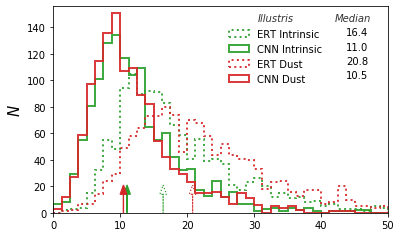

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6,3.8))

max_count = 0.
max_x = 50

labels = ['ERT Intrinsic','CNN Intrinsic','ERT Dust','CNN Dust']
colours = ['C2','C2','C3','C3']
linestyle = ['dotted','solid','dotted','solid']
fill=[False,True,False,True]

for lab, c, ls in zip(labels,colours,linestyle):
    
    counts = ax.hist(SMAPE[lab], bins=40, range=(0, max_x), alpha=.9, histtype='step', 
                     color=c, linestyle=ls, label=lab, lw=2)
    
    max_count = np.max([max_count, np.max(counts[0])])
    
    
ax.text(0.95, 0.93, 'Median', style='italic', horizontalalignment='right', 
        transform=ax.transAxes, alpha=0.8)

ax.text(0.72, 0.93, 'Illustris', style='italic', horizontalalignment='right', 
        transform=ax.transAxes, alpha=0.8)


for i, (key, c, ls, f) in enumerate(zip(labels,colours,linestyle,fill)):
    ax.text(0.94, 0.86-(i*0.07), '%.1f'%np.median(SMAPE[key]), 
            horizontalalignment='right', transform=ax.transAxes)

    ax.arrow(np.median(SMAPE[key]), 0, 0, 14, head_width=1, head_length=7, 
             fc=c, ec=c, ls=ls, fill=f, lw=1.2)

ax.set_xlim(0, max_x)
ax.set_ylim(0, max_count + 5)
# ax.set_xlabel('SMAPE (%)', size=15)
ax.set_ylabel('$N$', size=15)

ax.legend(frameon=False, bbox_to_anchor=(0.51, 0.83), bbox_transform=plt.gcf().transFigure, loc=2)

# fig.savefig('plots/smape_both_illustris.png', dpi=200, bbox_inches='tight')

## Added noise

In [9]:
sn = 50
predictors = si.load_arr('log_8','SFH')
illustris_dust, wl = si.load_spectra('Dust')
illustris_dust_noise = si.add_noise_flat(spec=illustris_dust, wl=wl, sn=sn)
# si.generate_standardisation(key='Dust Noise SN50', spec=illustris_dust_noise)
features = si.prepare_features(illustris_dust_noise, key='Dust Noise SN50', CNN=True)

In [10]:
## Noise Small
cnn_model = load_model('data/cnn_trained_illustris_dust_noise50.h5', 
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

prediction = cnn_model.predict(features[~si.train])

SMAPE['CNN Dust Noise'] = [si._SMAPE(predictors[~si.train][i], prediction[i]) \
                     * 100 for i in range(len(prediction))]


# ## Noise * 4
cnn_model = load_model('data/cnn_trained_illustris_dust_noise50_x4.h5',
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

prediction = cnn_model.predict(features[~si.train])

SMAPE['CNN Dust Noise x4'] = [si._SMAPE(predictors[~si.train][i], prediction[i]) \
                     * 100 for i in range(len(prediction))]


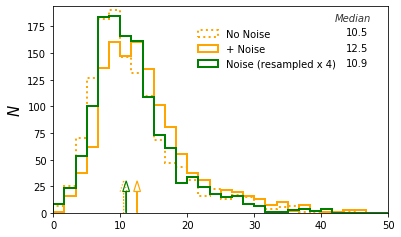

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,3.8))

max_count = 0.

labels = ['CNN Dust','CNN Dust Noise','CNN Dust Noise x4']

pretty_labels = ['No Noise','+ Noise','Noise (resampled x 4)']
colours = ['orange','orange','green']
linestyle = ['dotted','solid','solid']
fill=[False,False,False]

max_x = 50

for lab, plab, c, ls in zip(labels,pretty_labels,colours,linestyle):
    
    counts = ax.hist(SMAPE[lab], bins=30, range=(0, max_x), alpha=1, histtype='step', 
                     color=c, linestyle=ls, label=plab, lw=2)
    
    max_count = np.max([max_count, np.max(counts[0])])
    
    
ax.text(0.95, 0.93, 'Median', style='italic', horizontalalignment='right', 
        transform=ax.transAxes, alpha=0.8)

for i, (key, c, ls, f) in enumerate(zip(labels,colours,linestyle,fill)):
    ax.text(0.94, 0.86-(i*0.075), '%.1f'%np.median(SMAPE[key]), 
            horizontalalignment='right', transform=ax.transAxes)

    ax.arrow(SMAPE[key][np.argsort(SMAPE[key])[int(len(SMAPE[key])/2.)]], 0, 
             0, 20, head_width=1, head_length=10, fc=c, ec=c, ls=ls, fill=f, lw=1.2)


ax.set_xlim(0,max_x)
ax.set_ylim(0, max_count + 4)
# ax.set_xlabel('SMAPE (%)', size=15)
ax.set_ylabel('$N$', size=15)

ax.legend(frameon=False, bbox_to_anchor=(0.44, 0.83), bbox_transform=plt.gcf().transFigure, loc=2)

# fig.savefig('plots/smape_noise_illustris.png', dpi=200, bbox_inches='tight')

## Signal to Noise

In [12]:
sn = 20
predictors = si.load_arr('log_8','SFH')
illustris_dust, wl = si.load_spectra('Dust')
illustris_dust_noise = si.add_noise_flat(spec=illustris_dust, wl=wl, sn=sn)
# si.generate_standardisation(key='Dust Noise SN20', spec=illustris_dust_noise)
features = si.prepare_features(illustris_dust_noise, key='Dust Noise SN20', CNN=True)

In [13]:
cnn_model = load_model('data/cnn_trained_illustris_dust_noise20.h5', 
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

prediction = cnn_model.predict(features[~si.train])

SMAPE['CNN Dust Noise 20'] = [si._SMAPE(predictors[~si.train][i], prediction[i]) \
                     * 100 for i in range(len(prediction))]

cnn_model = load_model('data/cnn_trained_illustris_dust_noise20_x4.h5',
                       custom_objects={'_SMAPE_tf': si._SMAPE_tf})

prediction = cnn_model.predict(features[~si.train])

SMAPE['CNN Dust Noise 20 x4'] = [si._SMAPE(predictors[~si.train][i], prediction[i]) \
                     * 100 for i in range(len(prediction))]

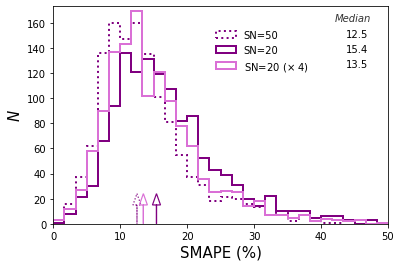

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

max_count = 0.

# labels = ['SN50','SN20','SN20-resamp']
labels = ['CNN Dust Noise','CNN Dust Noise 20','CNN Dust Noise 20 x4']

pretty_labels = ['SN=50','SN=20','SN=20 ($\\times$ 4)']
colours = ['purple','purple','orchid']
linestyle = ['dotted','solid','solid']
fill=[False,False,False]

max_x = 50

for lab, plab, c, ls in zip(labels,pretty_labels,colours,linestyle):
    
    counts = ax.hist(SMAPE[lab], bins=30, range=(0, max_x), alpha=1, histtype='step', 
                     color=c, linestyle=ls, label=plab, lw=2)
    
    max_count = np.max([max_count, np.max(counts[0])])
    
    
ax.text(0.95, 0.93, 'Median', style='italic', horizontalalignment='right', 
        transform=ax.transAxes, alpha=0.8)

# ax.text(0.72, 0.93, 'Illustris', style='italic', horizontalalignment='right', 
#         transform=ax.transAxes, alpha=0.8)

for i, (key, c, ls, f) in enumerate(zip(labels,colours,linestyle,fill)):
    ax.text(0.94, 0.86-(i*0.07), '%.1f'%np.median(SMAPE[key]), 
            horizontalalignment='right', transform=ax.transAxes)

    ax.arrow(SMAPE[key][np.argsort(SMAPE[key])[int(len(SMAPE[key])/2.)]], 0, 
             0, 15, head_width=1.2, head_length=9, fc=c, ec=c, ls=ls, fill=f, lw=1.2)


ax.set_xlim(0,max_x)
ax.set_ylim(0, max_count + 4)
ax.set_xlabel('SMAPE (%)', size=15)
ax.set_ylabel('$N$', size=15)

ax.legend(frameon=False, bbox_to_anchor=(0.48, 0.83), bbox_transform=plt.gcf().transFigure, loc=2)

# fig.savefig('plots/smape_noise_SN_illustris.png', dpi=200, bbox_inches='tight')